In [10]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Descargar el dataset de "Flight Status Prediction" desde Kaggle y extraerlo
!kaggle datasets download robikscube/flight-delay-dataset-20182022

Dataset URL: https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022
License(s): CC0-1.0
flight-delay-dataset-20182022.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:

# Extraer el archivo zip descargado
with zipfile.ZipFile("/content/flight-delay-dataset-20182022.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/flight_data")


# Ruta donde están los archivos extraídos
folder_path = "/content/flight_data/"

In [4]:

# Teniendo en cuenta el tamaño de las bases de datos,solo usaremos una muestra, que será los datos para 2018
# Lista de los archivos CSV que quieres leer
file_names = [
    "Combined_Flights_2018.csv"
]

# Diccionario para almacenar los DataFrames
dataframes = {}

# Leer cada archivo CSV y almacenarlo en el diccionario
for file in file_names:
    file_path = os.path.join(folder_path, file)
    year = file.replace("Combined_Flights_", "").replace(".csv", "")  # Extraer el año de registros
    dataframes[year] = pd.read_csv(file_path)

In [5]:
# Resumen estadístico
print(dataframes['2018'].describe())



         CRSDepTime       DepTime  DepDelayMinutes      DepDelay  \
count  5.689512e+06  5.604132e+06     5.602937e+06  5.602937e+06   
mean   1.330341e+03  1.334473e+03     1.346201e+01  1.014888e+01   
std    4.913570e+02  5.048563e+02     4.420411e+01  4.536897e+01   
min    1.000000e+00  1.000000e+00     0.000000e+00 -1.280000e+03   
25%    9.150000e+02  9.160000e+02     0.000000e+00 -6.000000e+00   
50%    1.323000e+03  1.327000e+03     0.000000e+00 -2.000000e+00   
75%    1.735000e+03  1.745000e+03     7.000000e+00  7.000000e+00   
max    2.359000e+03  2.400000e+03     2.625000e+03  2.625000e+03   

            ArrTime  ArrDelayMinutes       AirTime  CRSElapsedTime  \
count  5.598897e+06     5.586619e+06  5.580241e+06    5.689506e+06   
mean   1.462641e+03     1.368363e+01  1.101716e+02    1.389089e+02   
std    5.405804e+02     4.402848e+01  7.058990e+01    7.288408e+01   
min    1.000000e+00     0.000000e+00 -1.244000e+03   -9.900000e+01   
25%    1.046000e+03     0.000000e+00 

In [8]:
# Resumen estadístico de ArrDelay Nuestra variable objetivo
print(dataframes['2018']['ArrDelay'].describe())

count    5.586619e+06
mean     5.416295e+00
std      4.746066e+01
min     -1.290000e+03
25%     -1.400000e+01
50%     -6.000000e+00
75%      8.000000e+00
max      2.635000e+03
Name: ArrDelay, dtype: float64


In [40]:
print(dataframes['2018']['ArrDelay'].max())
print(dataframes['2018']['ArrDelay'].min())
print(dataframes['2018']['ArrDelay'].mean())

2635.0
-1290.0
5.4162945423699025


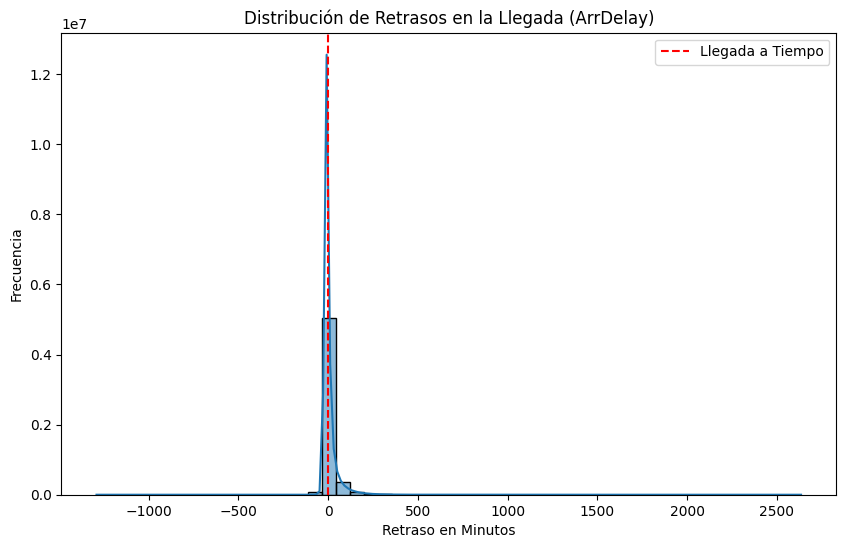

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(dataframes['2018']['ArrDelay'], bins=50, kde=True)
plt.title('Distribución de Retrasos en la Llegada (ArrDelay)')
plt.xlabel('Retraso en Minutos')
plt.ylabel('Frecuencia')
plt.axvline(0, color='red', linestyle='--', label='Llegada a Tiempo')
plt.legend()
plt.show()

In [19]:
# Calcular el promedio de retraso por aeropuerto
avg_delay_by_origin = dataframes['2018'].groupby('Dest')['ArrDelay'].mean().reset_index()
avg_delay_by_origin.columns = ['Aeropuerto Destino', 'Promedio Retraso']
# Filtrar los 5 aeropuertos con más retraso (valores positivos)
top_5_delays = avg_delay_by_origin.nlargest(5, 'Promedio Retraso')

# Filtrar los 5 aeropuertos con llegadas más tempranas (valores negativos)
top_5_early_arrivals = avg_delay_by_origin.nsmallest(5, 'Promedio Retraso')

# Filtrar los 5 aeropuertos que llegan a tiempo (valores cercanos a cero)
on_time_arrivals = avg_delay_by_origin[(avg_delay_by_origin['Promedio Retraso'] >= -10) &
                                        (avg_delay_by_origin['Promedio Retraso'] <= 10)]
top_5_on_time = on_time_arrivals.nlargest(5, 'Promedio Retraso')  # Elegir los mejores entre los que están a tiempo

# Combinar todos en un solo DataFrame
combined_results = pd.concat([top_5_delays, top_5_early_arrivals, top_5_on_time])

<ipython-input-20-da8bb12a9087>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Promedio Retraso', y='Aeropuerto Destino', data=combined_results, palette='Set2')


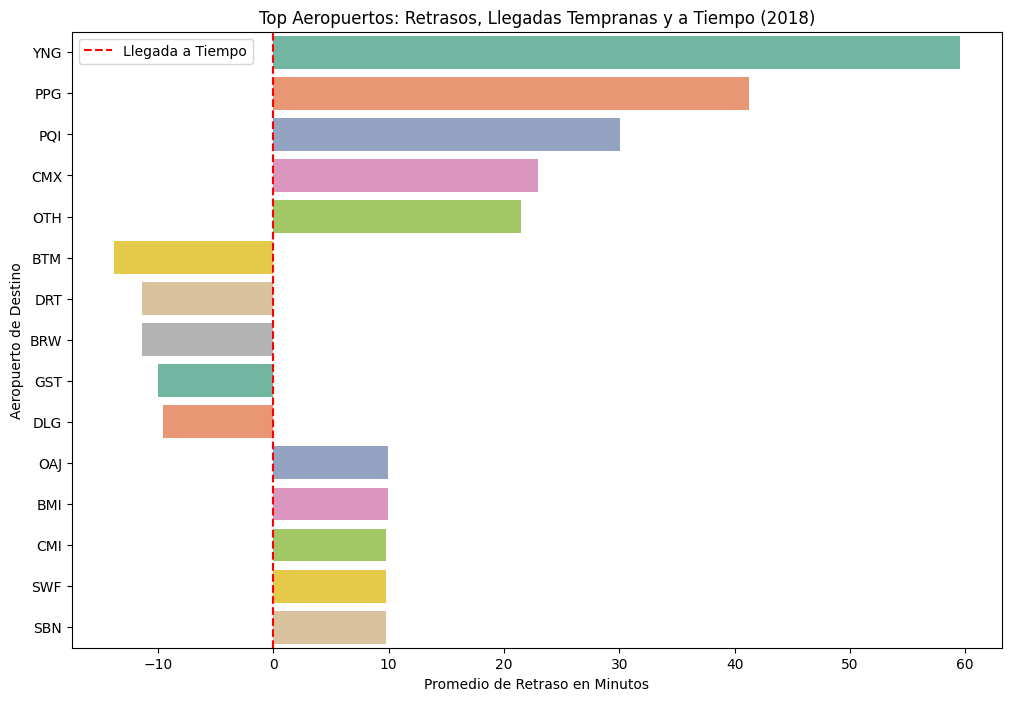

In [20]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Promedio Retraso', y='Aeropuerto Destino', data=combined_results, palette='Set2')
plt.title('Top Aeropuertos: Retrasos, Llegadas Tempranas y a Tiempo (2018)')
plt.xlabel('Promedio de Retraso en Minutos')
plt.ylabel('Aeropuerto de Destino')
plt.axvline(0, color='red', linestyle='--', label='Llegada a Tiempo')
plt.legend()
plt.show()

In [21]:
city_info = dataframes['2018'][['Dest', 'DestCityName']].drop_duplicates()

# Combinar con los resultados combinados
combined_results = combined_results.merge(city_info, left_on='Aeropuerto Destino', right_on='Dest', how='left')

print("Lista de Aeropuertos y Ciudades:")
for index, row in combined_results.iterrows():
    print(f"Aeropuerto: {row['Aeropuerto Destino']} - Ciudad: {row['DestCityName']}")

Lista de Aeropuertos y Ciudades:
Aeropuerto: YNG - Ciudad: Youngstown/Warren, OH
Aeropuerto: PPG - Ciudad: Pago Pago, TT
Aeropuerto: PQI - Ciudad: Presque Isle/Houlton, ME
Aeropuerto: CMX - Ciudad: Hancock/Houghton, MI
Aeropuerto: OTH - Ciudad: North Bend/Coos Bay, OR
Aeropuerto: BTM - Ciudad: Butte, MT
Aeropuerto: DRT - Ciudad: Del Rio, TX
Aeropuerto: BRW - Ciudad: Barrow, AK
Aeropuerto: GST - Ciudad: Gustavus, AK
Aeropuerto: DLG - Ciudad: Dillingham, AK
Aeropuerto: OAJ - Ciudad: Jacksonville/Camp Lejeune, NC
Aeropuerto: BMI - Ciudad: Bloomington/Normal, IL
Aeropuerto: CMI - Ciudad: Champaign/Urbana, IL
Aeropuerto: SWF - Ciudad: Newburgh/Poughkeepsie, NY
Aeropuerto: SBN - Ciudad: South Bend, IN


In [22]:
# Resumen general de los datos
print("Número total de observaciones:", dataframes['2018'].shape[0])
print("Número total de variables:", dataframes['2018'].shape[1])
print("\nTipos de variables:\n", dataframes['2018'].dtypes)
print("\nValores faltantes:\n", dataframes['2018'].isnull().sum())

Número total de observaciones: 5689512
Número total de variables: 61

Tipos de variables:
 FlightDate             object
Airline                object
Origin                 object
Dest                   object
Cancelled                bool
                       ...   
ArrDel15              float64
ArrivalDelayGroups    float64
ArrTimeBlk             object
DistanceGroup           int64
DivAirportLandings    float64
Length: 61, dtype: object

Valores faltantes:
 FlightDate                 0
Airline                    0
Origin                     0
Dest                       0
Cancelled                  0
                       ...  
ArrDel15              102893
ArrivalDelayGroups    102893
ArrTimeBlk                 0
DistanceGroup              0
DivAirportLandings         1
Length: 61, dtype: int64


In [24]:
# Resumen de calidad de los datos
missing_values = dataframes['2018'].isnull().sum()
missing_percentage = (missing_values / dataframes['2018'].shape[0]) * 100
quality_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(quality_summary)

# Duplicados
duplicates = dataframes['2018'].duplicated().sum()
print(f"\nNúmero de duplicados: {duplicates}")

# Identificación de valores extremos (outliers)
outliers = dataframes['2018'][(dataframes['2018']['ArrDelay'] > 60) | (dataframes['2018']['ArrDelay'] < -60)]
print(f"Número de outliers en ArrDelay: {outliers.shape[0]}")

                    Missing Values  Percentage
FlightDate                       0    0.000000
Airline                          0    0.000000
Origin                           0    0.000000
Dest                             0    0.000000
Cancelled                        0    0.000000
...                            ...         ...
ArrDel15                    102893    1.808468
ArrivalDelayGroups          102893    1.808468
ArrTimeBlk                       0    0.000000
DistanceGroup                    0    0.000000
DivAirportLandings               1    0.000018

[61 rows x 2 columns]

Número de duplicados: 0
Número de outliers en ArrDelay: 354751


In [41]:
print(dataframes['2018']['DepDelay'].max())
print(dataframes['2018']['DepDelay'].min())
print(dataframes['2018']['DepDelay'].mean())

2625.0
-1280.0
10.148876026983706


Estadísticas descriptivas para DepDelay:
 count    5.602937e+06
mean     1.014888e+01
std      4.536897e+01
min     -1.280000e+03
25%     -6.000000e+00
50%     -2.000000e+00
75%      7.000000e+00
max      2.625000e+03
Name: DepDelay, dtype: float64


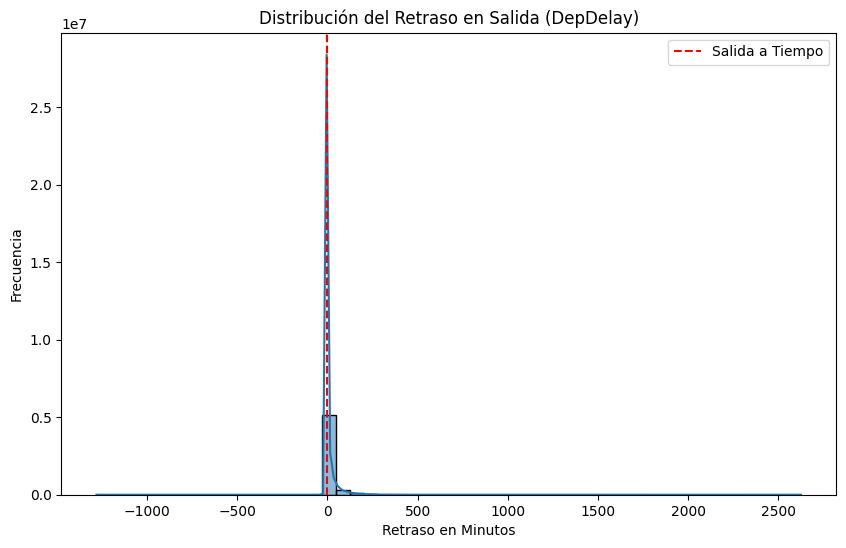

In [34]:
print("Estadísticas descriptivas para DepDelay:\n", dataframes['2018']['DepDelay'].describe())

# Gráfico de distribución para DepDelay
plt.figure(figsize=(10, 6))
sns.histplot(dataframes['2018']['DepDelay'], bins=50, kde=True)
plt.title('Distribución del Retraso en Salida (DepDelay)')
plt.xlabel('Retraso en Minutos')
plt.ylabel('Frecuencia')
plt.axvline(0, color='red', linestyle='--', label='Salida a Tiempo')
plt.legend()
plt.show()

Correlaciones con ArrDelay:
 ArrDelay                           1.000000
ArrDelayMinutes                    0.981821
DepDelay                           0.959378
DepDelayMinutes                    0.956559
ArrivalDelayGroups                 0.879513
DepartureDelayGroups               0.833875
ArrDel15                           0.615918
DepDel15                           0.575360
TaxiOut                            0.216379
DepTime                            0.130860
WheelsOff                          0.126356
TaxiIn                             0.103253
CRSDepTime                         0.095700
CRSArrTime                         0.083648
WheelsOn                           0.039117
ActualElapsedTime                  0.037455
DOT_ID_Operating_Airline           0.034716
DOT_ID_Marketing_Airline           0.033171
ArrTime                            0.032115
Flight_Number_Operating_Airline    0.018340
Flight_Number_Marketing_Airline    0.018302
DestStateFips                      0.008026
Ori

<ipython-input-37-866be34692a4>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='viridis')


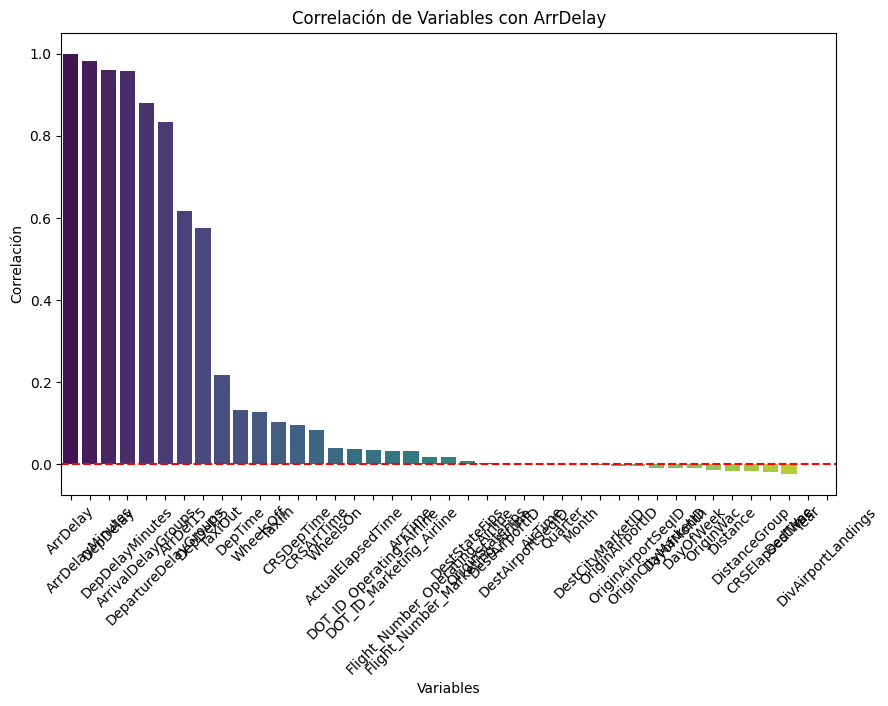

In [37]:
# Obtener solo las columnas numéricas
numeric_df = dataframes['2018'].select_dtypes(include=['number'])

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

# Extraer la correlación con ArrDelay
correlation_with_target = correlation_matrix['ArrDelay'].sort_values(ascending=False)

# Mostrar las correlaciones con ArrDelay
print("Correlaciones con ArrDelay:\n", correlation_with_target)

# Visualizar la correlación con ArrDelay en un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='viridis')
plt.title('Correlación de Variables con ArrDelay')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.axhline(0, color='red', linestyle='--')  # Línea horizontal en 0 para referencia
plt.xticks(rotation=45)
plt.show()

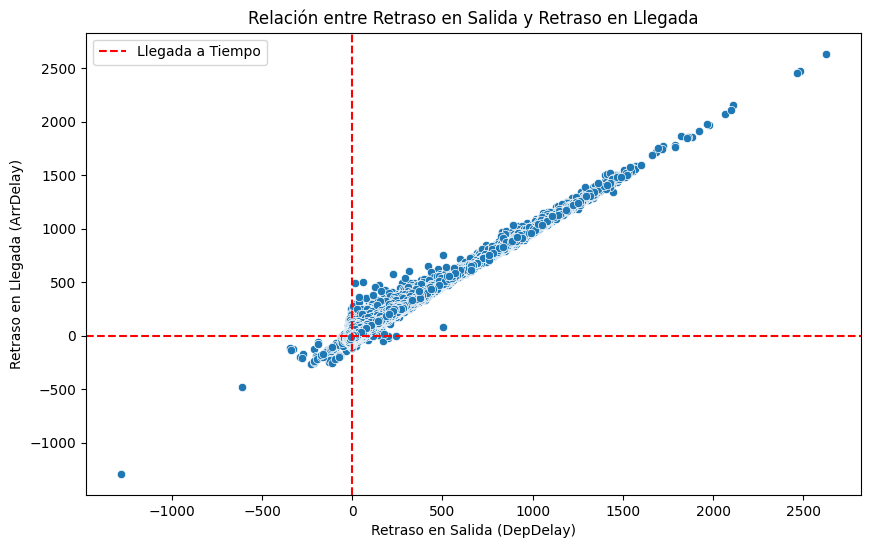

In [39]:
# Diagrama de dispersión entre DepDelay y ArrDelay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DepDelay', y='ArrDelay', data=dataframes['2018'])
plt.title('Relación entre Retraso en Salida y Retraso en Llegada')
plt.xlabel('Retraso en Salida (DepDelay)')
plt.ylabel('Retraso en Llegada (ArrDelay)')
plt.axhline(0, color='red', linestyle='--', label='Llegada a Tiempo')
plt.axvline(0, color='red', linestyle='--')
plt.legend()
plt.show()
